# Propensity Score Matching Demo

<br> A demonstration of Propensity Score matching (PSM). Given two groups (treated, untreated), build a pseudo-control group that has covariates balanced between the two groups. 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys, os, importlib, warnings

sys.path.insert(1, '../../src/')

import causal
from causal.PropensityScore import PropensityScore 
warnings.filterwarnings('ignore')

## load metadata

In [ ]:
foldername = '../../data/external/processed/metadata'
filename = '114213_taxonomy_collapsed_table_noNorm_rf.txt'

file_path = os.path.join(foldername, filename)
df = pd.read_csv(file_path, delimiter = '\t')
df.head()

## split dataframe into treatment and control groups

In [3]:
covariates = ['age_years', 'bmi','weight_kg',]
exact = ['sex', 'state']
group_variable = 'asd'
valid_values = {'untreat': 'I do not have this condition', 
                'treat': 'Diagnosed by a medical professional (doctor, physician assistant)'}

In [4]:
# get the treatment and untreated groups
treatment = df[df[group_variable] == valid_values['treat']]
notreatment = df[df[group_variable] == valid_values['untreat']]

NameError: name 'df' is not defined

## compute propensity scores and build pseudo-control group

In [58]:
import utils
importlib.reload(utils.PropensityScore)
from utils.PropensityScore import PropensityScore

"""
 Parameters
 ----------
     treatment: pd.DataFrame of treated group 
     notreatment: pd.DataFrame of untreated group
     covariates: list of column headers to include as covariates (must be numeric)
     exact: list of column headers that must have an exact match
     
 Functions
 ---------
     norm: applies normalization function to the dataframes. If None is given, apply unit mean, zero variance
     
     fit: calculates propensity score
     
     transform: matches treatment group from notreatment group with propensity score
        returns
        -------
            treatment: pd.DataFrame treatment group
            control: pd.DataFrame control group

"""
propensity = PropensityScore(treatment, notreatment, covariates, repeat = True)
propensity.norm(f = None) # optional
treatment, control = propensity.fit_transform()

0 entries dropped.


## verify that covariates are balanced between two groups
#### plot

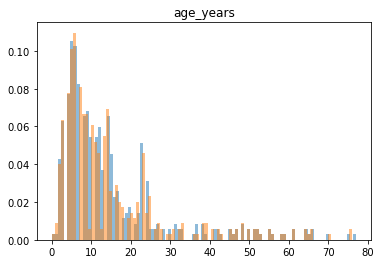

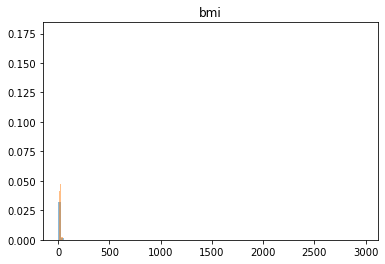

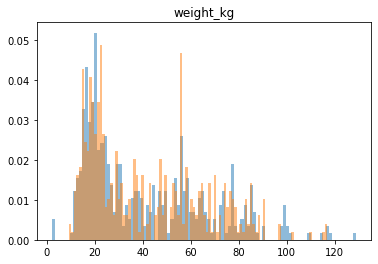

In [59]:
for covariate in covariates:
    for d in [treatment, control]:
        plt.hist(d[covariate], bins = 100, alpha = 0.5, density = True)
    plt.title(covariate)
    plt.show()    

#### summary statistics

In [91]:
treatment.describe()[covariates], control.describe()[covariates]

(        age_years          bmi   weight_kg
 count  456.000000   456.000000  456.000000
 mean    14.750877    36.045197   40.861586
 std     13.912439   211.338506   25.290165
 min      0.100000     0.390000    2.000000
 25%      6.000000    15.600000   20.000000
 50%     10.000000    17.980000   31.500000
 75%     17.000000    22.120000   57.250000
 max     77.000000  2968.520000  129.000000,
         age_years         bmi   weight_kg
 count  456.000000  456.000000  456.000000
 mean    14.732018   18.988355   41.442122
 std     13.949669    6.219972   24.119998
 min      0.000000    7.760000    9.000000
 25%      6.000000   15.325000   20.000000
 50%     10.000000   17.750000   36.000000
 75%     17.250000   21.107500   58.000000
 max     76.000000  108.840000  117.000000)

#### representative data

In [83]:
treatment[covariates + exact], control[covariates + exact]

(         bmi  weight_kg  height_cm      sex age_years
 20     13.61  18.000000     115.00     male         7
 71     13.27  24.000000     134.00     male         9
 152    16.88  31.000000     137.00     male        10
 191    19.11  55.000000     170.00     male        18
 211    16.24  14.000000      96.00     male       5.0
 ...      ...        ...        ...      ...       ...
 29193  19.83  29.000000     121.00     male         5
 29196  22.96  78.000000     185.00     male        23
 29203  14.06  22.000000     127.00     male         6
 29227  22.87  66.000000     170.00     male        14
 29595  16.60  37.194619     149.86  unknown      12.3
 
 [460 rows x 5 columns],
          bmi  weight_kg  height_cm      sex age_years
 25281  13.44  20.000000     122.00     male         7
 5834   14.30  24.000000     132.00     male         9
 7657   17.52  31.000000     134.00     male        10
 26969  19.96  55.000000     166.00     male        18
 4065   12.55  14.000000     109.00   

## check model coefficients 

In [84]:
for i, covariate in enumerate(covariates):
    print(covariate, propensity.model.coef_[0, i])

bmi -0.007866829358968014
weight_kg -1.5070625978940262
height_cm 0.017881267680723387


## evaluate ML

In [8]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys, os, importlib, warnings

sys.path.insert(1, '../../src/')

warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report


from sklearn import ensemble
from scipy.stats import randint


In [9]:
# define the metrics used 
metrics = {'Accuracy': balanced_accuracy_score,
          'Precision': precision_score,
          'Report': classification_report,
          'Recall': recall_score,}

In [10]:
# parameters for random search
xgb_parameters = {"n_estimators": [100, 250, 500, 1000],
             "learning_rate": [1, 0.1, 0.01],
             "max_depth": [1, 2],
             "random_state": [0]}

rf_parameters = {"max_depth": [3, None],
                     "bootstrap": [True, False],
                     "criterion": ["gini", "entropy"],
                     "class_weight": ["balanced"],
                     "n_estimators": [100, 250, 500, 1000]}

In [15]:
treatment.index, control.index

(Int64Index([   20,    71,   152,   191,   211,   284,   310,   320,   336,
               375,
             ...
             29068, 29109, 29156, 29157, 29187, 29193, 29196, 29203, 29227,
             29595],
            dtype='int64', length=460),
 Int64Index([25281,  5834,  7657, 26969,  4065,  1148,   757, 15365,  6791,
             15493,
             ...
             14531, 16579, 17457, 24206, 11393, 25912, 18298, 11162, 26147,
             29509],
            dtype='int64', length=460))